# Machine Learning Mini Project 1

In [183]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

## 2. Obtaining the Data

Finished downloading the dataset via IPUMS. Access data here: https://drive.google.com/drive/folders/18Tz9ySUJsW2GK4g0GCE8CKkG-amINGAI?usp=share_link  
*Note: I'm not sure whether sharing the data will violate their terms, so I set the access as restricted. If needed, I can share the access*

## 3.  Preparing the Data

### 3.1. Load Data
- There are 8734 observations in the data with 26 variables. No missing data has been found.

In [184]:
# Load the dataset
acs_data = pd.read_csv('usa_00001.csv')
# Check dataset
display(acs_data.head())
acs_data.shape

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,...,RACED,HISPAN,HISPAND,EDUC,EDUCD,EMPSTAT,EMPSTATD,INCWAGE,VETSTAT,VETSTATD
0,2021,202101,1484,2021010089049,7956.0,2021000014841,160001,4,1,7956.0,...,100,0,0,7,71,1,10,0,1,11
1,2021,202101,2264,2021010135123,9360.0,2021000022641,130201,4,1,9360.0,...,868,0,0,6,65,1,10,7000,1,11
2,2021,202101,2732,2021000004232,18564.0,2021000027321,260001,1,1,18408.0,...,100,0,0,11,115,1,10,145000,1,11
3,2021,202101,2732,2021000004232,18564.0,2021000027321,260001,1,2,28236.0,...,100,0,0,11,115,1,10,125000,1,11
4,2021,202101,2888,2021000014267,19032.0,2021000028881,80001,1,1,19032.0,...,100,0,0,10,101,1,10,90000,1,11


(8734, 26)

In [185]:
# Check missing values
print(acs_data.isna().sum())
# Check data type
acs_data.info()

YEAR        0
SAMPLE      0
SERIAL      0
CBSERIAL    0
HHWT        0
CLUSTER     0
STRATA      0
GQ          0
PERNUM      0
PERWT       0
NCHILD      0
NCHLT5      0
SEX         0
AGE         0
MARST       0
RACE        0
RACED       0
HISPAN      0
HISPAND     0
EDUC        0
EDUCD       0
EMPSTAT     0
EMPSTATD    0
INCWAGE     0
VETSTAT     0
VETSTATD    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8734 entries, 0 to 8733
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YEAR      8734 non-null   int64  
 1   SAMPLE    8734 non-null   int64  
 2   SERIAL    8734 non-null   int64  
 3   CBSERIAL  8734 non-null   int64  
 4   HHWT      8734 non-null   float64
 5   CLUSTER   8734 non-null   int64  
 6   STRATA    8734 non-null   int64  
 7   GQ        8734 non-null   int64  
 8   PERNUM    8734 non-null   int64  
 9   PERWT     8734 non-null   float64
 10  NCHILD    8734 non-null   int64  
 11  NCHL

### 3.2. Clean and Create Variables

##### a. Education

In [186]:
# Load crosswalk dataset
crosswalk = pd.read_csv('PPHA_30545_MP01-Crosswalk.csv')
# Merge with original dataset and create acontinuoous measure of education
acs_data = acs_data.merge(crosswalk, left_on = 'EDUCD', right_on = 'educd')
# Clean dataset
acs_data = acs_data.loc[:, ~acs_data.T.duplicated(keep = 'first')]
# Check dataset
acs_data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,...,HISPAN,HISPAND,EDUC,EDUCD,EMPSTAT,EMPSTATD,INCWAGE,VETSTAT,VETSTATD,educdc
0,2021,202101,1484,2021010089049,7956.0,2021000014841,160001,4,1,7956.0,...,0,0,7,71,1,10,0,1,11,14.0
1,2021,202101,3980,2021000091014,3744.0,2021000039801,250001,1,1,3744.0,...,0,0,7,71,1,10,8000,1,11,14.0
2,2021,202101,6632,2021000275893,4524.0,2021000066321,240001,1,1,4368.0,...,0,0,7,71,1,10,35000,1,11,14.0
3,2021,202101,7412,2021000326772,8736.0,2021000074121,110001,1,3,25272.0,...,0,0,7,71,1,10,6000,2,20,14.0
4,2021,202101,7568,2021000338207,7488.0,2021000075681,270201,1,2,9048.0,...,0,0,7,71,1,10,32800,1,11,14.0


##### b. Dummy variables

In [187]:
# high school diploma
acs_data['hsdip'] = np.where(
    (acs_data['EDUCD'].between(63, 64)) | (acs_data['EDUCD'].between(81, 83)), # 63&64 for high school&GED holders, 81-83 for associate degree holders
    1,
    0
)
# four-year college diploma
acs_data['coldip'] = np.where(
    (acs_data['EDUCD'] == 101) | (acs_data['EDUCD'].between(114, 116)), # 101 for bachelor degree holders, 114-116 for higher degree holders including Master, Doctor and Professional
    1,
    0) # people with more than 4 years coleege education while without a degree is not counted as earning a bachelor degree

In [188]:
# Race equals White
acs_data['white'] = np.where(acs_data['RACE'] == 1, 1, 0) # Whites are 1
# Race equals Black
acs_data['black'] = np.where(acs_data['RACE'] == 2, 1, 0) # Blacks are 2
# Race equals Hispanic
acs_data['hispanic'] = np.where(
    (acs_data['HISPAN'] != 0) & (acs_data['HISPAN'] != 9), # 0 means not hispanic, 9 means Not reported
    1,
    0
)

In [189]:
# Marital status equals married
acs_data['married'] = np.where(
    (acs_data['MARST'] == 1) | (acs_data['MARST'] == 2), # MARST = 1 or 2 refers to married
    1,
    0
)
# Sex equals female
acs_data['female'] = np.where(acs_data['SEX'] == 2, 1, 0) # Females are 2, Males are 1
# Veteran status equals true
acs_data['vet'] = np.where(acs_data['VETSTAT'] == 2, 1, 0) # Vetearns are 2

##### c. Interaction Terms

In [190]:
# Interaction between high school diploma and continous years of education measure
acs_data['hsd*edu'] = acs_data['hsdip'] * acs_data['educdc']
# Interaction between bachelor degree diploma and continous years of education measure
acs_data['col*edu'] = acs_data['coldip'] * acs_data['educdc']

##### d. Squared and Log Term

In [191]:
# Age squared
acs_data['age_sq'] = np.power(acs_data['AGE'], 2)
acs_data[['AGE', 'age_sq']].head()

,AGE,age_sq
0,20,400
1,56,3136
2,23,529
3,61,3721
4,59,3481


In [192]:
# Natural log of wage
# Drop samples with zero wage
acs_data = acs_data[acs_data['INCWAGE'] != 0]
# Create log column
acs_data['incwage_ln'] = np.log(acs_data['INCWAGE'])
acs_data[['INCWAGE','incwage_ln']].head(10)

,INCWAGE,incwage_ln
1,8000,8.987197
2,35000,10.463103
3,6000,8.699515
4,32800,10.398184
5,45800,10.732039
6,28400,10.254144
7,50000,10.819778
8,30000,10.308953
9,58000,10.968198
10,60000,11.002100


In [193]:
# Clean dataset
acs_data.columns = map(str.lower, acs_data.columns) # Format column names
acs_data.head()

,year,sample,serial,cbserial,hhwt,cluster,strata,gq,pernum,perwt,...,white,black,hispanic,married,female,vet,hsd*edu,col*edu,age_sq,incwage_ln
1,2021,202101,3980,2021000091014,3744.0,2021000039801,250001,1,1,3744.0,...,0,1,0,0,0,0,0.0,0.0,3136,8.987197
2,2021,202101,6632,2021000275893,4524.0,2021000066321,240001,1,1,4368.0,...,1,0,0,0,0,0,0.0,0.0,529,10.463103
3,2021,202101,7412,2021000326772,8736.0,2021000074121,110001,1,3,25272.0,...,1,0,0,0,0,1,0.0,0.0,3721,8.699515
4,2021,202101,7568,2021000338207,7488.0,2021000075681,270201,1,2,9048.0,...,1,0,0,1,1,0,0.0,0.0,3481,10.398184
5,2021,202101,8972,2021000433020,2964.0,2021000089721,230001,1,1,2964.0,...,1,0,0,0,1,0,0.0,0.0,1089,10.732039


## 4. Data Analysis

### 4.1. Descriptive Statistics
- As shown in the table below, all data are from year 2021. The median yearly wage is 45,000 dollars, with very high s.d. at 73,524 dollars; Median years of education is 14, with 22 years being the highest;
- The female dummy variable shows that there are more men in the data than female, that may cause data bias
- The mean age is around 42, with 65 being the oldest
- For race, white approximately account for half of the sample, however, the percentage of black is pretty low
- For number of children, most people have 1 child. Other characteristics of the data can be found in the table.

In [194]:
# Statistical Distribution of certain variables
# Select relevant columns
features =  ['year', 'incwage', 'incwage_ln',
             'educdc', 'female', 'age', 'age_sq',
             'white', 'black', 'hispanic',
             'married', 'nchild', 
             'vet', 'hsdip', 'coldip',
             'hsd*edu', 'col*edu']
# Distribution
acs_data[features].describe()

,year,incwage,incwage_ln,educdc,female,age,age_sq,white,black,hispanic,married,nchild,vet,hsdip,coldip,hsd*edu,col*edu
count,8279.0,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000,8279.000000
mean,2021.0,62455.094818,10.554271,14.294238,0.480734,41.762290,1920.193502,0.663969,0.081894,0.157628,0.550670,0.803116,0.042155,0.322865,0.407900,4.057495,6.924025
std,0.0,73524.701263,1.113068,2.995834,0.499659,13.271243,1119.156852,0.472378,0.274220,0.364414,0.497456,1.119523,0.200954,0.467600,0.491474,5.898684,8.395624
min,2021.0,10.000000,2.302585,0.000000,0.000000,18.000000,324.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.0,24000.000000,10.085809,12.000000,0.000000,31.000000,961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2021.0,45000.000000,10.714418,14.000000,0.000000,42.000000,1764.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2021.0,75000.000000,11.225243,16.000000,1.000000,53.000000,2809.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,12.000000,16.000000
max,2021.0,770000.000000,13.554146,22.000000,1.000000,65.000000,4225.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,14.000000,22.000000


### 4.2. Scatter Plot of Ln(wage) and Education
- I interpret the wage variable as income in the title because the data dictionary says *wage* here refers to all income earned in the previoud calendar year as an employee.

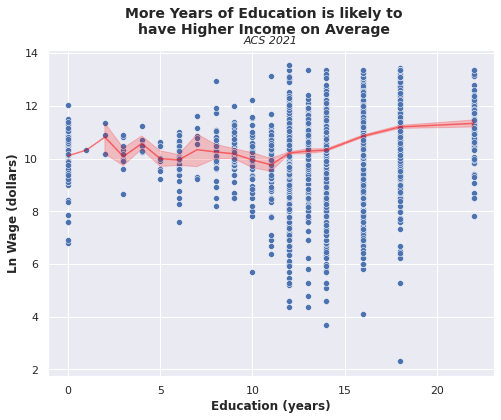

In [239]:
# Plot
sns.set(rc = {'figure.figsize' :(8, 6)})
sns.scatterplot(data = acs_data, x = 'educdc', y = 'incwage_ln', palette = "flare")
sns.lineplot(data = acs_data, x = 'educdc', y = 'incwage_ln', color = 'red', alpha = 0.5)

plt.suptitle('More Years of Education is likely to\nhave Higher Income on Average', fontsize = 14, weight = 'bold')
plt.title('ACS 2021', fontsize = 11, style = 'italic')
plt.xlabel('Education (years)', fontsize = 12, weight = 'bold')
plt.ylabel('Ln Wage (dollars)', fontsize = 12, weight = 'bold')
plt.yticks(fontsize = 11)
plt.ticklabel_format(style = 'plain', useOffset = False, axis = 'x')

### 4.3. Models

In [195]:
# Select independent variables
features_ols = features[3:13]
# Run regression
reg_ols = smf.ols(f'incwage_ln ~ {"+".join(features_ols)}', data = acs_data).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:             incwage_ln   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     326.6
Date:                Wed, 25 Jan 2023   Prob (F-statistic):               0.00
Time:                        22:33:56   Log-Likelihood:                -11256.
No. Observations:                8279   AIC:                         2.253e+04
Df Residuals:                    8268   BIC:                         2.261e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6760      0.124     45.798      0.0

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


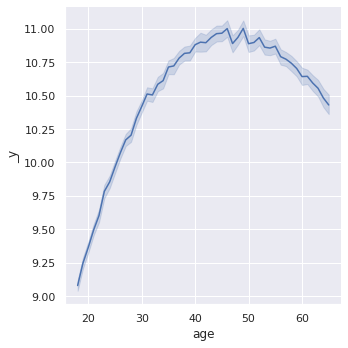

In [241]:
# Predictions on age
x_pred = acs_data['age']
y_pred = reg_ols.predict(acs_data)
sns.relplot(x_pred, y_pred, kind = "line")

#### Interpretations

- (a).  The model explained <u>28.2% of variation in log wages</u> with the dataset, based on the adjusted R square calue.
- (b).  The coefficient of continuous education measure on an individual's wage is 0.0973. In other words, we will expcet a **9.73% increase on average in one's yearly wage with an additional year of education obtained**, given all else equal. It's **statistically significant as the p value is smaller than o.o1**, meaning that even at the 99% significance level it's still significantly different from the null hypothesis. **Practically I belive it's also very significant**, since a <u>nearly 10% of yearly income is huge, given that to get the benefit only 1 year additional education is required<u/>, if nothing elese changed.
- (c). The model predicts that a person will have <u>highest yearly wage at the age of 49</u>. See above plots for details.
- (d). The model predicts that males will have higher wage than women, all else equal. The coefficient of *female dummy* is **-0.4294, meaning that we will expect to get a 42.9% decrease in yearly wage for a woman compared to a man with all other variables included in the model being equal.** The decrease it's huge. On the one hand, it says something to the truth, the gender pay gap exists in most industries even take differnt industry, education level etc into consideration. However, looking at the table created in Q4.1, we noticed that **there are way more samples being male rather than females in the dataset(75% are male). Also more than 50% people got married while a=only a few of them have a college or higher degree.** Women with higher education have higher wages on average> it's likely the data does not represent women well. Also, getting married will lead to extra work for women, given that half people are married, it could also lead to data bias.
- (e). Given all else equal, we will expect a **6.46% increase in one's yearly wage on average; However, we will expect a 17.63% decrease for someone being black, holding all else equal**. **Both coefficient are significant at the 95% level**, while the negative effect of being black has a lower p value, meaning that it's statistically more significant(at 99% level). Practically, although the increase of being white is not as high as getting more education, increasing age, or getting married, 6% increase is not neglectable. However, the disadvantages blacks get are the worst among all other characteristics included in the model.

### 4.4. Scatter Plot of Ln(wage) and Education by Education Credentials

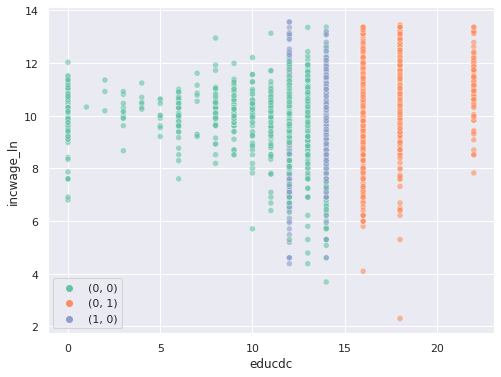

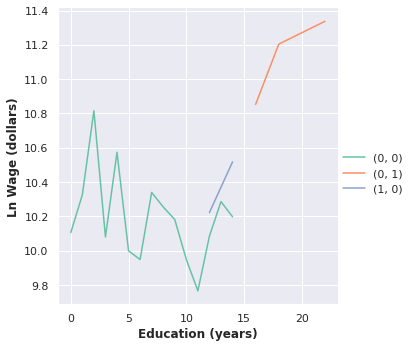

In [256]:
# Plot
sns.scatterplot(data = acs_data, x = 'educdc', y = 'incwage_ln',hue = acs_data[['hsdip', 'coldip']].apply(tuple, axis=1), palette = "Set2", alpha = 0.6)
sns.relplot(data = acs_data, x = 'educdc', y = 'incwage_ln',hue = acs_data[['hsdip', 'coldip']].apply(tuple, axis=1), palette = "Set2", kind = "line", ci = None)

plt.xlabel('Education (years)', fontsize = 12, weight = 'bold')
plt.ylabel('Ln Wage (dollars)', fontsize = 12, weight = 'bold')
plt.yticks(fontsize = 11)
plt.ticklabel_format(style = 'plain', useOffset = False, axis = 'x')